Running on device: cuda
Data found in: ./unzipped_data/faces_02/part3
Starting Training...


Epoch 1/10: 100%|██████████| 82/82 [00:16<00:00,  4.83it/s]


Epoch 1 Results:
Train Loss: 672.25 | Train Error: +/- 21.06 years
Val Loss:   275.73 | Val Error:   +/- 13.59 years
--------------------------------------------------


Epoch 2/10: 100%|██████████| 82/82 [00:17<00:00,  4.72it/s]


Epoch 2 Results:
Train Loss: 124.49 | Train Error: +/- 8.40 years
Val Loss:   155.54 | Val Error:   +/- 9.17 years
--------------------------------------------------


Epoch 3/10: 100%|██████████| 82/82 [00:16<00:00,  4.87it/s]


Epoch 3 Results:
Train Loss: 95.80 | Train Error: +/- 7.42 years
Val Loss:   260.40 | Val Error:   +/- 12.91 years
--------------------------------------------------


Epoch 4/10: 100%|██████████| 82/82 [00:16<00:00,  4.84it/s]


Epoch 4 Results:
Train Loss: 72.75 | Train Error: +/- 6.41 years
Val Loss:   119.18 | Val Error:   +/- 8.06 years
--------------------------------------------------


Epoch 5/10: 100%|██████████| 82/82 [00:17<00:00,  4.75it/s]


Epoch 5 Results:
Train Loss: 56.18 | Train Error: +/- 5.60 years
Val Loss:   128.37 | Val Error:   +/- 8.62 years
--------------------------------------------------


Epoch 6/10: 100%|██████████| 82/82 [00:16<00:00,  4.83it/s]


Epoch 6 Results:
Train Loss: 53.86 | Train Error: +/- 5.55 years
Val Loss:   160.61 | Val Error:   +/- 9.81 years
--------------------------------------------------


Epoch 7/10: 100%|██████████| 82/82 [00:16<00:00,  4.87it/s]


Epoch 7 Results:
Train Loss: 40.60 | Train Error: +/- 4.80 years
Val Loss:   99.29 | Val Error:   +/- 7.30 years
--------------------------------------------------


Epoch 8/10: 100%|██████████| 82/82 [00:17<00:00,  4.74it/s]


Epoch 8 Results:
Train Loss: 33.90 | Train Error: +/- 4.43 years
Val Loss:   101.48 | Val Error:   +/- 7.40 years
--------------------------------------------------


Epoch 9/10: 100%|██████████| 82/82 [00:16<00:00,  4.88it/s]


Epoch 9 Results:
Train Loss: 28.32 | Train Error: +/- 3.98 years
Val Loss:   104.80 | Val Error:   +/- 7.49 years
--------------------------------------------------


Epoch 10/10: 100%|██████████| 82/82 [00:16<00:00,  4.84it/s]


Epoch 10 Results:
Train Loss: 26.38 | Train Error: +/- 3.86 years
Val Loss:   106.85 | Val Error:   +/- 7.59 years
--------------------------------------------------
Model saved as 'age_model_resnet18.pth'


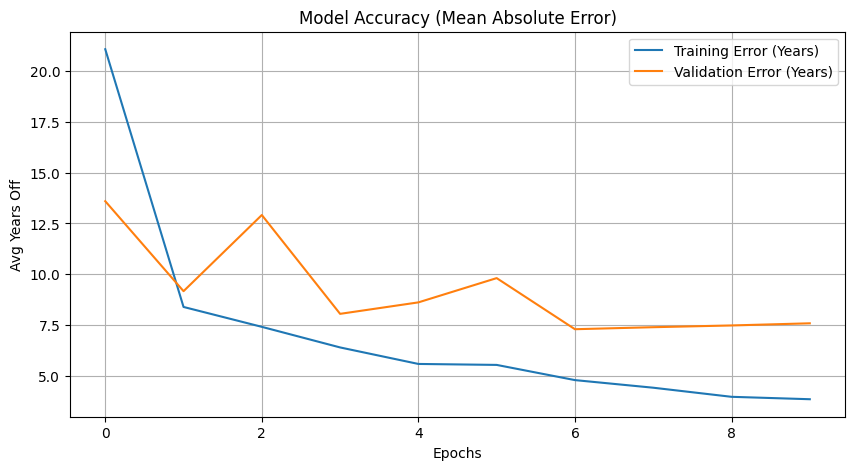

Graph saved as 'learning_curve.png'


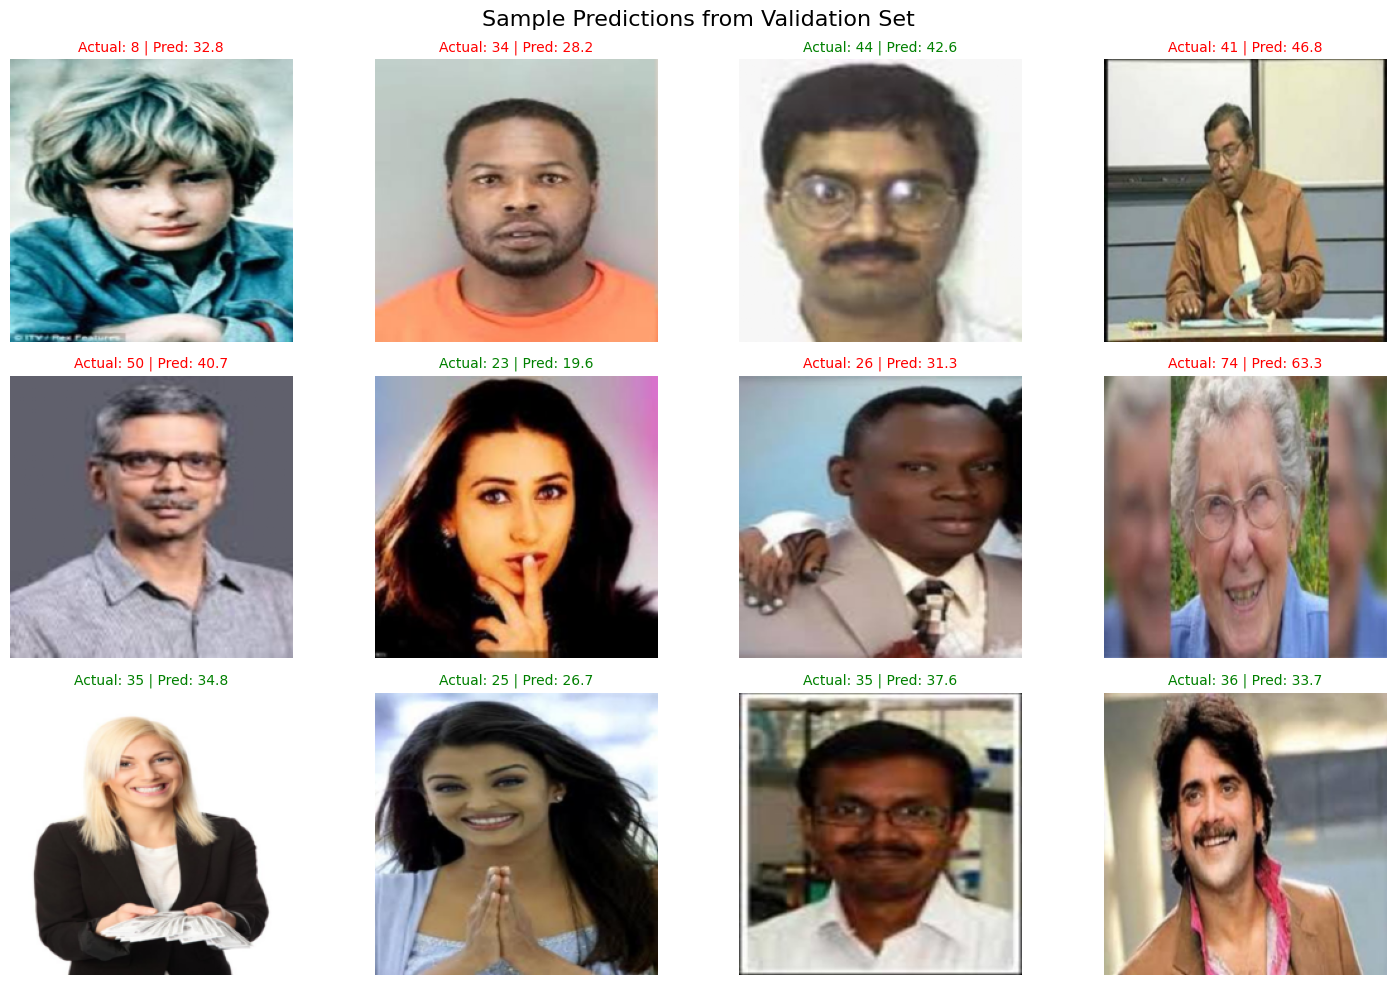

In [3]:
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np


ZIP_FILE_NAME = "archive.zip"
EXTRACT_PATH = "./unzipped_data"
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Running on device: {DEVICE}")


if not os.path.exists(EXTRACT_PATH):
    print(f"Extracting {ZIP_FILE_NAME}...")
    if os.path.exists(ZIP_FILE_NAME):
        with zipfile.ZipFile(ZIP_FILE_NAME, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("Extraction Complete!")
    else:
        raise FileNotFoundError(f"Could not find {ZIP_FILE_NAME}. Please drag and drop it to the Files sidebar.")

image_folder = EXTRACT_PATH
for root, dirs, files in os.walk(EXTRACT_PATH):
    if any(f.endswith('.jpg') for f in files):
        image_folder = root
        break
print(f"Data found in: {image_folder}")

class AgeDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        filename = os.path.basename(img_path)

        # Parse Age from filename (Format: Age_Gender_Race_Date.jpg)
        try:
            label = int(filename.split('_')[0])
        except:
            label = 25 # Fallback for corrupted names

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

all_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_loader = DataLoader(AgeDataset(train_files, transform), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(AgeDataset(val_files, transform), batch_size=BATCH_SIZE)


model = models.resnet18(weights='IMAGENET1K_V1')
# Modify final layer for Regression (1 output)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)
model = model.to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []
train_maes = []
val_maes = []

print("Starting Training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    running_mae = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_mae += torch.abs(outputs - labels).sum().item()

    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_mae += torch.abs(outputs - labels).sum().item()

    # Calculate Averages
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_train_mae = running_mae / len(train_files)
    avg_val_mae = val_mae / len(val_files)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_maes.append(avg_train_mae)
    val_maes.append(avg_val_mae)

    print(f"Epoch {epoch+1} Results:")
    print(f"Train Loss: {avg_train_loss:.2f} | Train Error: +/- {avg_train_mae:.2f} years")
    print(f"Val Loss:   {avg_val_loss:.2f} | Val Error:   +/- {avg_val_mae:.2f} years")
    print("-" * 50)

torch.save(model.state_dict(), "age_model_resnet18.pth")
print("Model saved as 'age_model_resnet18.pth'")

plt.figure(figsize=(10, 5))
plt.plot(train_maes, label='Training Error (Years)')
plt.plot(val_maes, label='Validation Error (Years)')
plt.title('Model Accuracy (Mean Absolute Error)')
plt.xlabel('Epochs')
plt.ylabel('Avg Years Off')
plt.legend()
plt.grid(True)
plt.savefig('learning_curve.png')
plt.show()
print("Graph saved as 'learning_curve.png'")

def show_predictions(loader, model):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    with torch.no_grad():
        preds = model(images).squeeze()

    plt.figure(figsize=(15, 10))
    num_images = min(12, len(images))

    for i in range(num_images):
        ax = plt.subplot(3, 4, i + 1)
        img = images[i].cpu().clone()
        # Denormalize
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0).numpy()

        plt.imshow(img)
        actual = int(labels[i].item())
        predicted = preds[i].item()

        diff = abs(actual - predicted)
        color = 'green' if diff <= 5 else 'red'

        plt.title(f"Actual: {actual} | Pred: {predicted:.1f}", color=color, fontsize=10)
        plt.axis('off')

    plt.suptitle("Sample Predictions from Validation Set", fontsize=16)
    plt.tight_layout()
    plt.show()

show_predictions(val_loader, model)